## Part 1 - Common Analysis

Import all necessary libraries

In [1]:
from pyproj import Transformer, Geod
import geojson
import pandas as pd
import matplotlib.pyplot as plt
import gzip
import shutil
from sklearn.linear_model import LinearRegression
import numpy as np

Wildfire dataset taken from USGS \
Since the unzipped json was too big to upload on GitHub, I compressed the json file (see [compress_decompress_json.ipynb](compress_decompress_json.ipynb)). If you've downloaded the zipped json file from my GitHub, simply upzip with the following code and proceed with the rest of the notebook

In [2]:
## decompress gz if needed
# input_gz_file = 'data_raw/USGS_Wildland_Fire_Combined_Dataset.json.gz'
# FILENAME = 'data_raw/USGS_Wildland_Fire_Combined_Dataset.json'


# with gzip.open(input_gz_file, 'rb') as f_in:
#     with open(FILENAME, 'wb') as f_out:
#         shutil.copyfileobj(f_in, f_out)

# print(f"File decompressed and saved as {FILENAME}")

In [3]:
FILENAME = "/Users/dianechiang/Desktop/data_512/data_512_project/project/part_1/data_raw/USGS_Wildland_Fire_Combined_Dataset.json"

Odessa, TX is my assigned city

In [4]:
CITY_LOCATIONS = {
    'odessa': {'city': 'Odessa',
               'latlon' : [31.88, -102.35]}
}

Read in Wildfire data

In [5]:
print(f"Attempting to open '{FILENAME}'")
geojson_file = open(FILENAME,"r")
print(f"Using GeoJSON module to load sample file '{FILENAME}'")
gj_data = geojson.load(geojson_file)
geojson_file.close()

Attempting to open '/Users/dianechiang/Desktop/data_512/data_512_project/project/part_1/data_raw/USGS_Wildland_Fire_Combined_Dataset.json'
Using GeoJSON module to load sample file '/Users/dianechiang/Desktop/data_512/data_512_project/project/part_1/data_raw/USGS_Wildland_Fire_Combined_Dataset.json'


Filter Wildfire data to consist of fires that happened between 1961 - 2024. We are only interested in data spanning from the 1964 - 2024 in this analysis

In [6]:
gj_feature_filtered = [feature for feature in gj_data['features'] if (feature['attributes']['Fire_Year'] >= 1961) & (feature['attributes']['Fire_Year'] <= 2024) ]

In [7]:
len(gj_feature_filtered)

118500

In [8]:
#    Transform feature geometry data
#
#    The function takes one parameter, a list of ESRI:102008 coordinates that will be transformed to EPSG:4326
#    The function returns a list of coordinates in EPSG:4326
def convert_ring_to_epsg4326(ring_data=None):
    converted_ring = list()

    # We use a pyproj transformer that converts from ESRI:102008 to EPSG:4326 to transform the list of coordinates
    to_epsg4326 = Transformer.from_crs("ESRI:102008","EPSG:4326")
    # We'll run through the list transforming each ESRI:102008 x,y coordinate into a decimal degree lat,lon
    for coord in ring_data:
        if len(coord) < 2: 
            break
        lat,lon = to_epsg4326.transform(coord[0],coord[1])
        new_coord = lat,lon
        converted_ring.append(new_coord)
    return converted_ring

In [9]:
#    The function takes two parameters
#        A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
#        Ring_data - a list of decimal degree coordinates for the fire boundary
#
#    The function returns the average miles from boundary to the place
#
def average_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    # create a list to store our results
    distances_in_meters = list()
    # run through each point in the converted ring data
    for point in ring:
        if point[0] and point[1]:
            # calculate the distance
            d = geodcalc.inv(place[1],place[0],point[1],point[0])
            distances_in_meters.append(d[2])
    #print("Got the following list:",distances_in_meters)
    # convert meters to miles
    distances_in_miles = [meters*0.00062137 for meters in distances_in_meters]
    # the esri polygon shape (the ring) requires that the first and last coordinates be identical to 'close the region
    # we remove one of them so that we don't bias our average by having two of the same point
    distances_in_miles_no_dup = distances_in_miles[1:]
    # now, average miles
    average = sum(distances_in_miles_no_dup)/len(distances_in_miles_no_dup)
    return average

Save computed all the average wildfire distances from Odessa, TX in the `gj_wf_distance` dictionary

In [10]:
gj_wf_distance = {}

In [11]:
place = CITY_LOCATIONS["odessa"]

for idx, wf_feature in enumerate(gj_feature_filtered):
    # print(idx)  # commented out for 
    wf_year = wf_feature['attributes']['Fire_Year']
    wf_name = wf_feature['attributes']['Listed_Fire_Names'].split(',')[0]
    wf_size = wf_feature['attributes']['GIS_Acres']
    wf_type = wf_feature['attributes']['Assigned_Fire_Type']

    if 'rings' in wf_feature['geometry']:
        ring_data = wf_feature['geometry']['rings'][0]
    elif 'curveRings' in wf_feature['geometry']:
        if len(wf_feature['geometry']['curveRings']) > 1:
            ring_data = wf_feature['geometry']['curveRings'][1]
        else:
            ring_data = wf_feature['geometry']['curveRings'][0]
    else:
        raise Exception("HEY! No compatible geometry in this fire data!!!")
    
    # Compute using the average distance to all points on the perimeter
    avg_distance = average_distance_from_place_to_fire_perimeter(place['latlon'],ring_data)
    gj_wf_distance[idx] = [wf_name, wf_year, wf_size, wf_type, avg_distance]

In [12]:
len(gj_wf_distance)

118500

Write the wildfire data (fire_name, fire_year, fire_size, fire_type, and avg_distance_from_odessa) to a dataframe and save it as `df_gj_wf_distance.csv` to avoid having to run the above code to get distance as it takes awhile (~30 minutes at least)

In [13]:
df_gj_wf_distance = pd.DataFrame.from_dict(gj_wf_distance, orient="index", columns=["fire_name", "fire_year", "fire_size", "fire_type", "avg_dis_from_odessa"])
df_gj_wf_distance.to_csv("data_intermediate/df_gj_wf_distance.csv")

Read from the saved `df_gj_wf_distance.csv` if needed

In [14]:
## read from csv
# df_gj_wf_distance = pd.read_csv("/Users/dianechiang/Desktop/data_512/project/df_gj_wf_distance.csv")

## Visualizations
### Visual 1: Wildfire Count at Every 50-Mile Interval from Odessa, TX, up to 1800 Miles
Bucket each average wildfire distance in 50-mile interval up to 1800 miles and plot a histogram that showcases the number of wildfires at each 50-mile-interval

In [16]:
def categorize_distance(distance):
    """Bucketize distance in 50-mile intervals"""
    return ((distance - 1) // 50) + 1

In [17]:
df_gj_wf_distance['distance_category'] = df_gj_wf_distance['avg_dis_from_odessa'].apply(categorize_distance)

Filter entire `df_gj_wf_distance` to keep only the average wildfire distance that's less than 1800 miles

In [38]:
df_within_1800_from_odessa = df_gj_wf_distance[df_gj_wf_distance['avg_dis_from_odessa'] <= 1800]

Plot the histogram

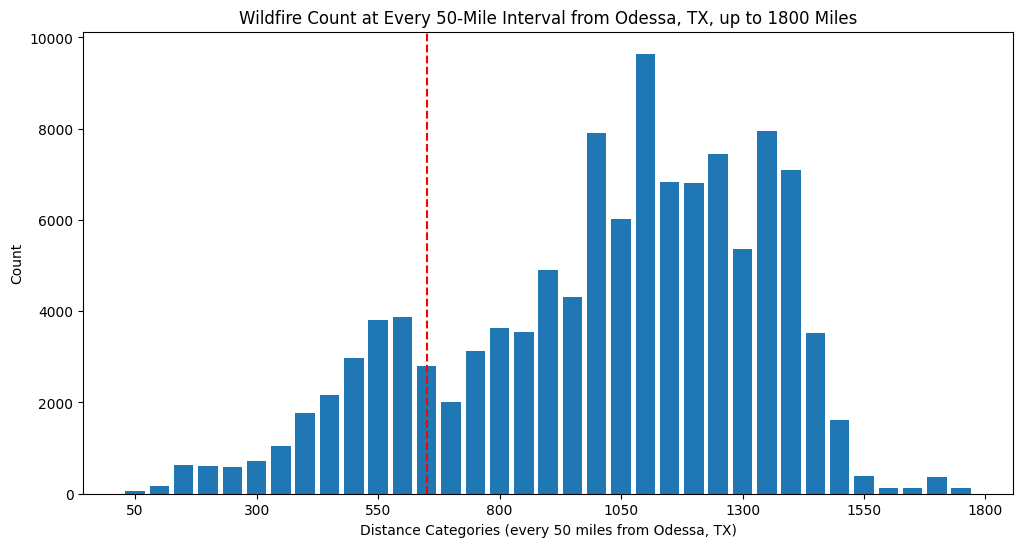

In [36]:
min_cat = int(df_within_1800_from_odessa['distance_category'].min())
max_cat = int(df_within_1800_from_odessa['distance_category'].max())
plt.figure(figsize=(12, 6))
plt.hist(df_within_1800_from_odessa['distance_category'], bins=range(min_cat, max_cat + 1), align='left', rwidth=0.8)
plt.axvline(x = 13, color = 'r', linestyle='--', label = '650 miles from Odessa, TX')
plt.xlabel("Distance Categories (every 50 miles from Odessa, TX)")
plt.ylabel("Count")
plt.title("Wildfire Count at Every 50-Mile Interval from Odessa, TX, up to 1800 Miles")

xtick_positions = range(min_cat, max_cat + 1, 5)  # every 5th category (corresponding to 5*50 = 250 miles)
xtick_labels = [x * 50 for x in xtick_positions]

plt.xticks(ticks=xtick_positions, labels=xtick_labels)

plt.show()

### Visual 2: Total Acres Burned per Year for Fires Occurring within a 650-Mile Radius of Odessa, TX
Sum the total acres burned by year from fires that occured within a 650 mile distance from Odessa, TX

Filter to only keep fires that are at an average distance less than 650 miles

In [39]:
df_within_650_miles_away_from_odessa = df_gj_wf_distance[df_gj_wf_distance['avg_dis_from_odessa'] <= 650]

Sum the fire size by year

In [40]:
df_sum_fire_size = df_within_650_miles_away_from_odessa.groupby("fire_year")['fire_size'].agg('sum').reset_index()

Plot the time series graph

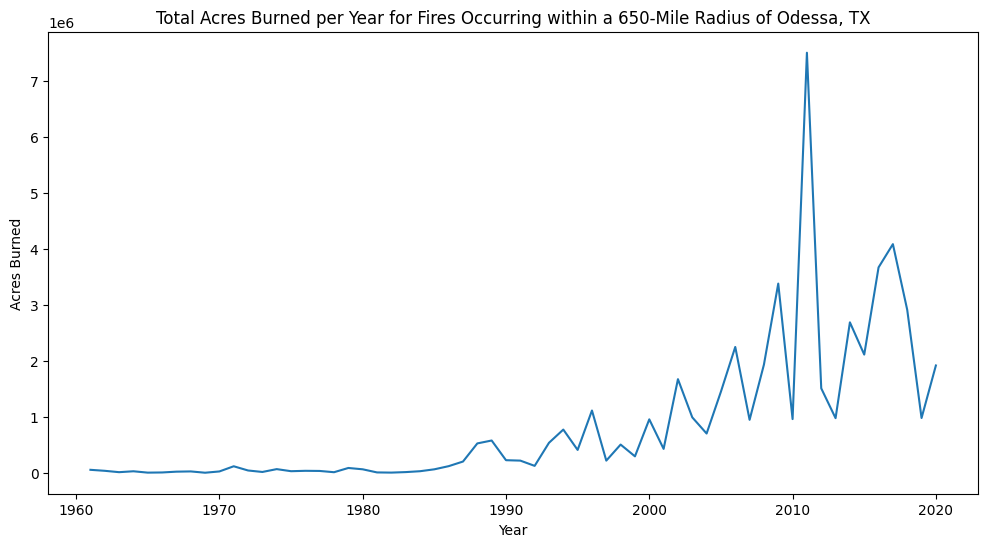

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(df_sum_fire_size['fire_year'], df_sum_fire_size['fire_size'])
plt.ylabel("Acres Burned")
plt.xlabel("Year")
plt.title("Total Acres Burned per Year for Fires Occurring within a 650-Mile Radius of Odessa, TX")
plt.show()

## Smoke Density Estimate

Calculate smoke estimate using the formula
$$S = k * (fire\_size\_in\_acres) * 0.0015625 * (\frac{1}{fire\_distance\_in\_miles})^2 * \alpha(1 + (Y - Y_0))$$
where $k$ has the unit $\mu g/m^3$ and $\alpha$ are both 5 for convenience and $Y_0$ is set to 1964 as the baseline year

The above formula takes into account that the smoke density is positively correlated to the size of the fire and inversely correlated to the distance of the fire (reference to [Inverse-square Law](https://en.wikipedia.org/wiki/Inverse-square_law)). Additionally, as global warming continues to be a prevalent issue, the formula also takes into account the positive relationship between smoke density and year, with the baseline year set as 1964.

In [ ]:
df_within_650_miles_away_from_odessa_from_1964 = df_within_650_miles_away_from_odessa[df_within_650_miles_away_from_odessa['fire_year'] >= 1964]

`calculate_smoke_density_estimate` uses the formula provided above to estimate the smoke density of each fire from 1964 to 2024

In [37]:
def calculate_smoke_density_estimate(fire_size, fire_distance, year):
    """Calculate the smoke density estimate using the formula"""
    y_0 = 1964
    k = alpha = 5
    smoke = k * fire_size * 0.0015625 * (1 / fire_distance) * alpha * (1 + (year - y_0))
    return smoke

df_within_650_miles_away_from_odessa_from_1964['smoke_density_estimate'] = df_within_650_miles_away_from_odessa_from_1964.apply(
                                                                            lambda row: calculate_smoke_density_estimate(row['fire_size'], 
                                                                                                                         row['avg_dis_from_odessa'], 
                                                                                                                         row['fire_year']), axis = 1)


Write the `df_within_650_miles_away_from_odessa_from_1964` to a csv file for the third visual in the [part_1_AQI.ipynb](part_1_AQI.ipynb)

In [26]:
df_within_650_miles_away_from_odessa_from_1964.to_csv("data_intermediate/df_within_650_miles_away_from_odessa_from_1964.csv")

## Annual Smoke Density Prediction for the next 25 years (2025 - 2050)

In the formula above, we defined that there is a positive relationship between estimated smoke density and year. Since we don't have fire size nor the fire distance, we will use a **linear regression model** fitted using the years and the estimated annual mean smoke density from 1964 - 2024 to roughly predict the annual mean smoke density for the next 25 years.

In [28]:
df = df_within_650_miles_away_from_odessa_from_1964.groupby('fire_year')['smoke_density_estimate'].mean().reset_index()
year = df['fire_year'].to_numpy().reshape(-1, 1)
smoke = df['smoke_density_estimate'].to_numpy()

model = LinearRegression()
model.fit(year, smoke)

LinearRegression()

In [29]:
future_years = np.array([y for y in range(2025, 2051)]).reshape(-1, 1)  # reshape(-1, 1) transform year from 1D array to 2D array
predicted_smoke_density = model.predict(future_years)

Below is the predicted annual mean smoke density for the next 25 years (2025–2050), generated using a linear regression model. Notably, since we lack information about potential future wildfires—such as the number of incidents, individual fire sizes, or their distances from Odessa, TX—this prediction is highly sensitive to other influencing factors. Additionally, the prediction is based solely on the year and does not account for other variables like climate change, forestry policies, or additional predictors.

In [31]:
d = {'year': [y for y in range(2025, 2051)], 'predicted_smoke_density': list(predicted_smoke_density)}
df_predicted_smoke_density = pd.DataFrame(data = d)
df_predicted_smoke_density

,year,predicted_smoke_density
0,2025,18.498
1,2026,18.838
2,2027,19.179
3,2028,19.519
4,2029,19.859
5,2030,20.199
6,2031,20.540
7,2032,20.880
8,2033,21.220
9,2034,21.561
